# Exploration Notebook (Dataset Wine)

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb
import umap.plot
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo

In [4]:
import sys

sys.path.append("../")
import evaluation
import visualization
import processing
import utils
from embedding_obj import EmbeddingObj
from dash_overlay import DashOverlay


## kNN-Exploration

Dataset: Image Segmentation, available at https://archive.ics.uci.edu/dataset/186/wine+quality

In [5]:
# fetch dataset
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

# metadata
print(image_segmentation.metadata)

# variable information
print(image_segmentation.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [10]:
X.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800003   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525320            115.744576     0.994697   
std       0.035034            17.749399             56.521854     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol  
count  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491800  
std       0.160787     0.148806     1.192712  
min       2.720000     0.220000     8.000000  
25%       3.110000     0.430000     9.500000  
50%       3.210000     0.510000    10.300000  
75%       3.320000     0.600000    11.300000  
max       4.010000     2.000000    14.900000

### knn-Graph from original UMAP-embedding

In [11]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_
connectivity_umap_knn = umap_mapper.graph_

graph_umap_knn = nx.Graph(connectivity_umap_knn)
edge_weights_umap_knn = [
    graph_umap_knn[u][v]["weight"] for u, v in graph_umap_knn.edges()
]

D:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<Axes: >

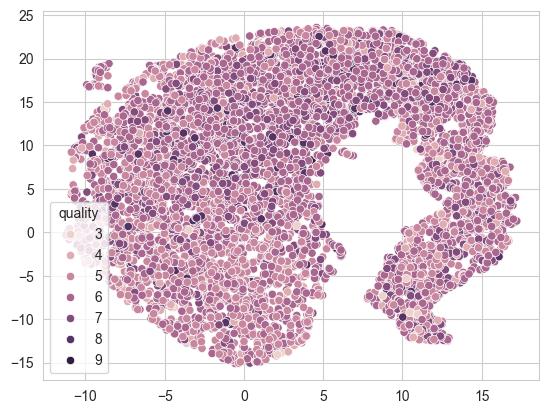

In [12]:
sb.scatterplot(x=umap_embedding[:, 0], y=umap_embedding[:, 1], hue=y["quality"])

### Feature-similarity: saturation-mean

In [13]:
feature_similarity = "pH"
labels = pd.Categorical(y["quality"]).codes

In [14]:
connectivity_pairwise = processing.compute_pairwise_dist(X, [feature_similarity])

<Axes: ylabel='Count'>

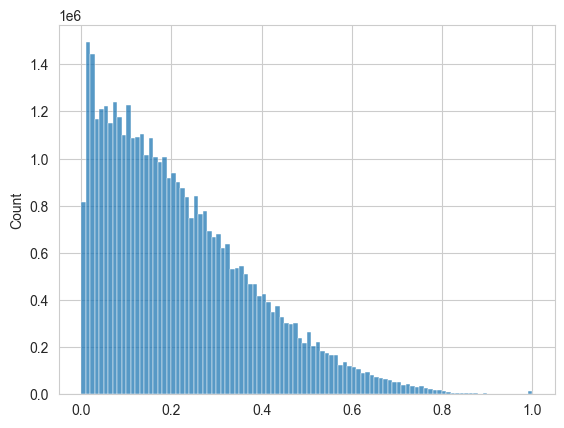

In [10]:
sb.histplot(connectivity_pairwise.flatten(), bins=100)

In [15]:
graph_knn_feat, edge_weights_knn_feat = processing.compute_knn(X, [feature_similarity],
                                                               n_neighbors=5)

### Display Connectivity-Graphs

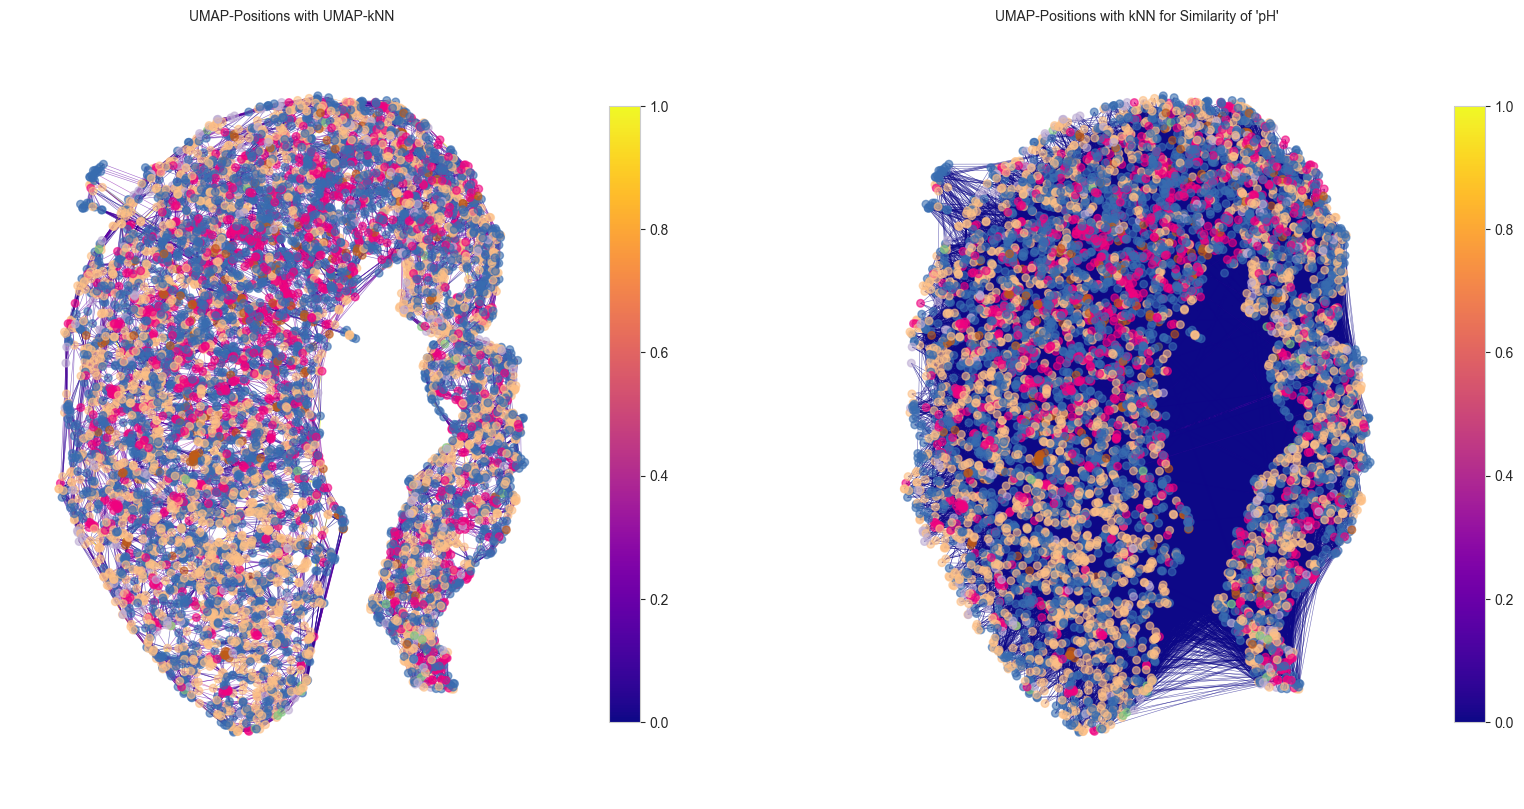

In [12]:
knn_list = [EmbeddingObj(graph=graph_umap_knn, embedding=umap_embedding,
                         edge_weights=edge_weights_umap_knn,
                         title="UMAP-Positions with UMAP-kNN"),
            EmbeddingObj(graph=graph_knn_feat, embedding=umap_embedding,
                         edge_weights=edge_weights_knn_feat,
                         title=f"UMAP-Positions with kNN for Similarity of '{feature_similarity}'")]

visualization.display_graphs(knn_list,
                             2,
                             labels=labels,
                             figsize=(20, 10))

### Force-directed exploration

In [16]:
force_iterations = processing.compute_iterations(graph=graph_knn_feat,
                                                 iterations=[0, 1, 3, 5, 13],
                                                 method="force-directed",
                                                 initial_pos=umap_embedding)

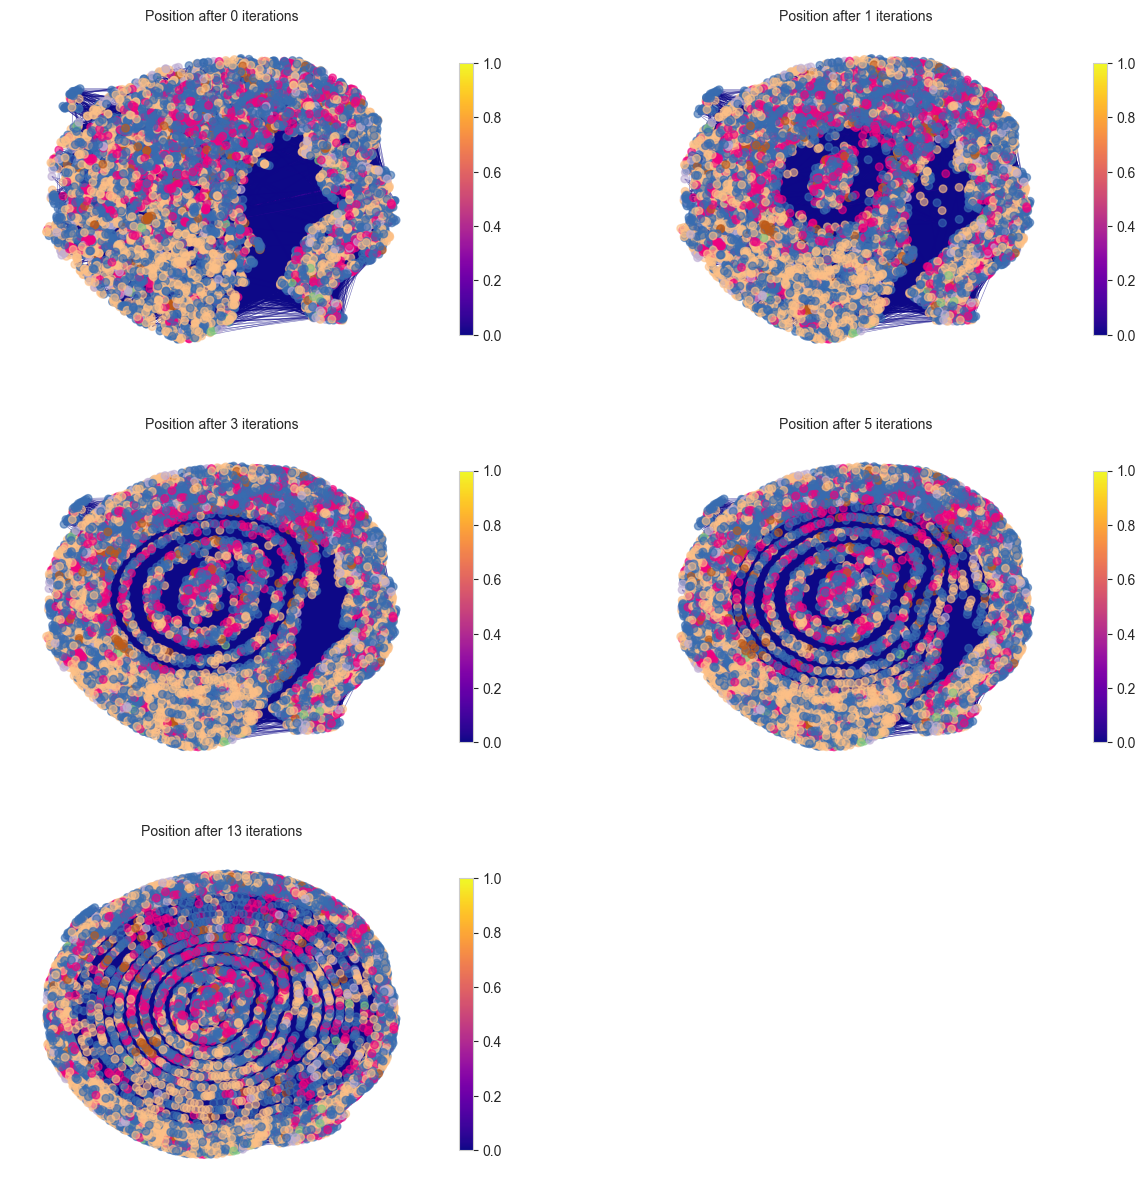

In [15]:
visualization.display_graphs(force_iterations, 2, labels=labels, show_edges=True)

## Evaluation-exploration

### Shepard Diagram

KeyboardInterrupt: 

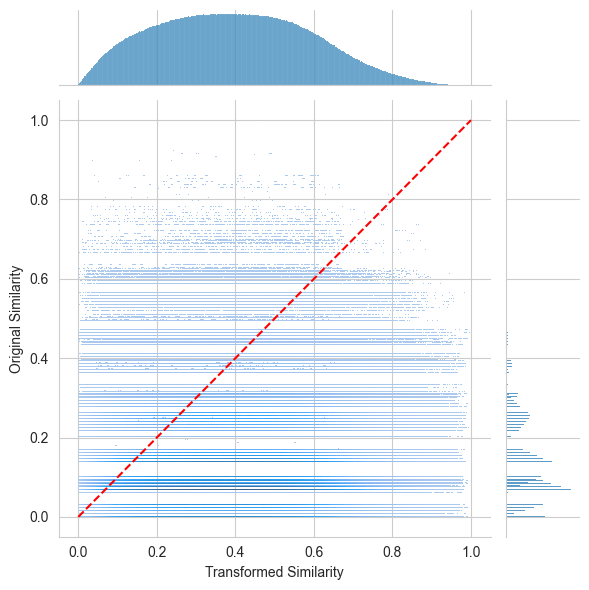

In [18]:
feature_similarity_values = np.float16(X[feature_similarity].values.reshape(-1, 1))

similarities_highdim = evaluation.compute_distance_matrix(feature_similarity_values)
similarities_lowdim = evaluation.compute_distance_matrix(umap_embedding)

scaler = MinMaxScaler()
similarities_highdim = scaler.fit_transform(
    similarities_highdim.reshape(-1, 1)
).flatten()
similarities_lowdim = scaler.fit_transform(similarities_lowdim.reshape(-1, 1)).flatten()

evaluation.plot_shepard_diagram(
    similarities_lowdim, similarities_highdim, feature_similarity
)

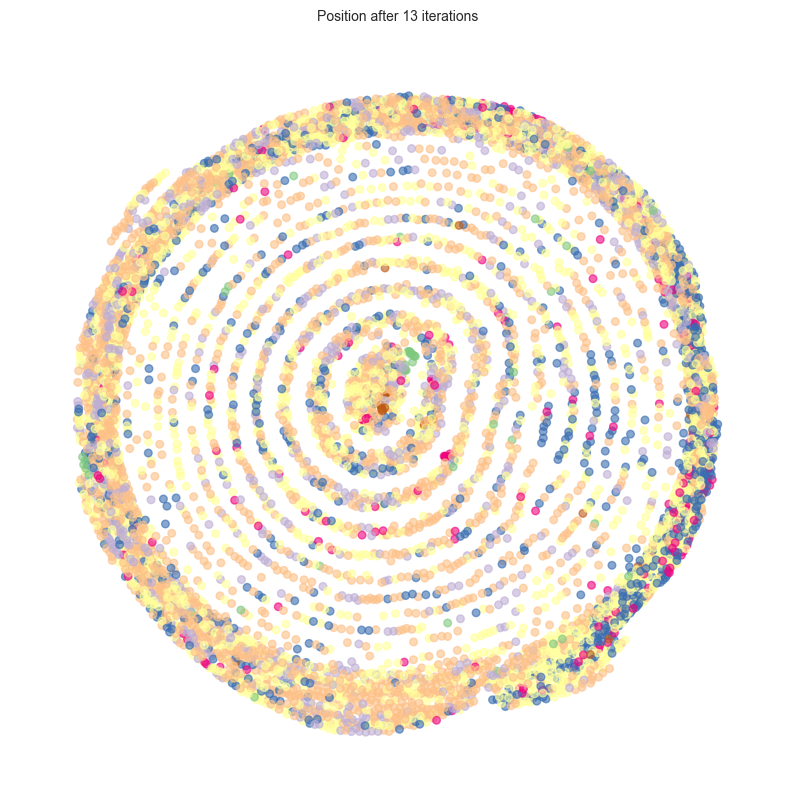

In [16]:
visualization.display_graphs([force_iterations[-1]],
                             1,
                             labels=X["pH"],
                             show_cbar=False,
                             figsize=(10, 10),
                             show_edges=False
                             )

In [17]:
similarities_lowdim = evaluation.compute_distance_matrix(force_iterations[-1].embedding)

scaler = MinMaxScaler()
similarities_lowdim = scaler.fit_transform(similarities_lowdim.reshape(-1, 1)).flatten()

# evaluation.plot_shepard_diagram(
#     similarities_lowdim, similarities_highdim, feature_similarity
# )

### Neighborhood-Preservation

In [20]:
accuracies = evaluation.compute_jaccard_distances(
    umap_mapper._raw_data, force_iterations[0].embedding, nhood_size=15
)
accuracies

array([0.5       , 0.15384615, 0.25      , ..., 0.30434783, 0.36363636,
       0.25      ])

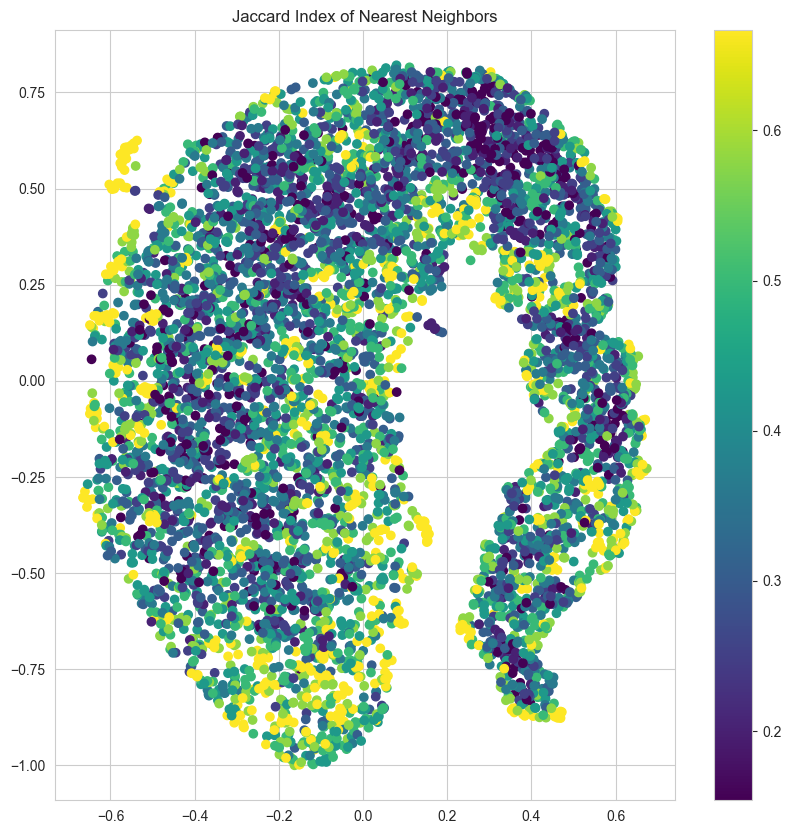

In [21]:
fig = plt.figure(figsize=(10, 10))
vmin = np.percentile(accuracies, 5)
vmax = np.percentile(accuracies, 95)

plt.scatter(
    force_iterations[0].embedding[:, 0],
    force_iterations[0].embedding[:, 1],
    c=accuracies,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar()
plt.title("Jaccard Index of Nearest Neighbors")
plt.show()

<Axes: title={'center': 'Colored by neighborhood Jaccard index'}>

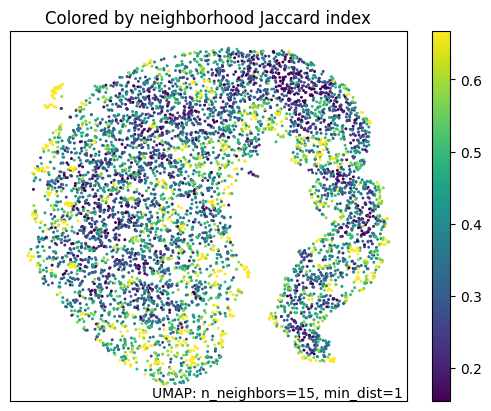

In [ ]:
umap.plot.diagnostic(umap_mapper, diagnostic_type="neighborhood", nhood_size=15)

### Sequence Difference View

In [31]:
sequence_diff_initial = evaluation.compute_sequence_diff(
    umap_mapper._raw_data, force_iterations[0].embedding, nhood_size=7
)

fig = plt.figure(figsize=(7, 7))
vmin = np.percentile(sequence_diff_initial, 5)
vmax = np.percentile(sequence_diff_initial, 95)

plt.scatter(
    force_iterations[0].embedding[:, 0],
    force_iterations[0].embedding[:, 1],
    c=sequence_diff_initial,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar()
plt.title("Sequence Difference View (initial embedding)")
plt.show()


KeyboardInterrupt: 

In [11]:
sequence_changes = np.zeros([umap_mapper._raw_data.shape[0]])

for iteration in force_iterations:
    iteration.m_jaccard = evaluation.compute_jaccard_distances(umap_mapper._raw_data,
                                                               iteration.embedding,
                                                               nhood_size=7)
    sequence_changes = np.vstack(
        [
            sequence_changes,
            evaluation.compute_sequence_change(
                force_iterations[0].m_jaccard, iteration.m_jaccard
            ),
        ]
    )

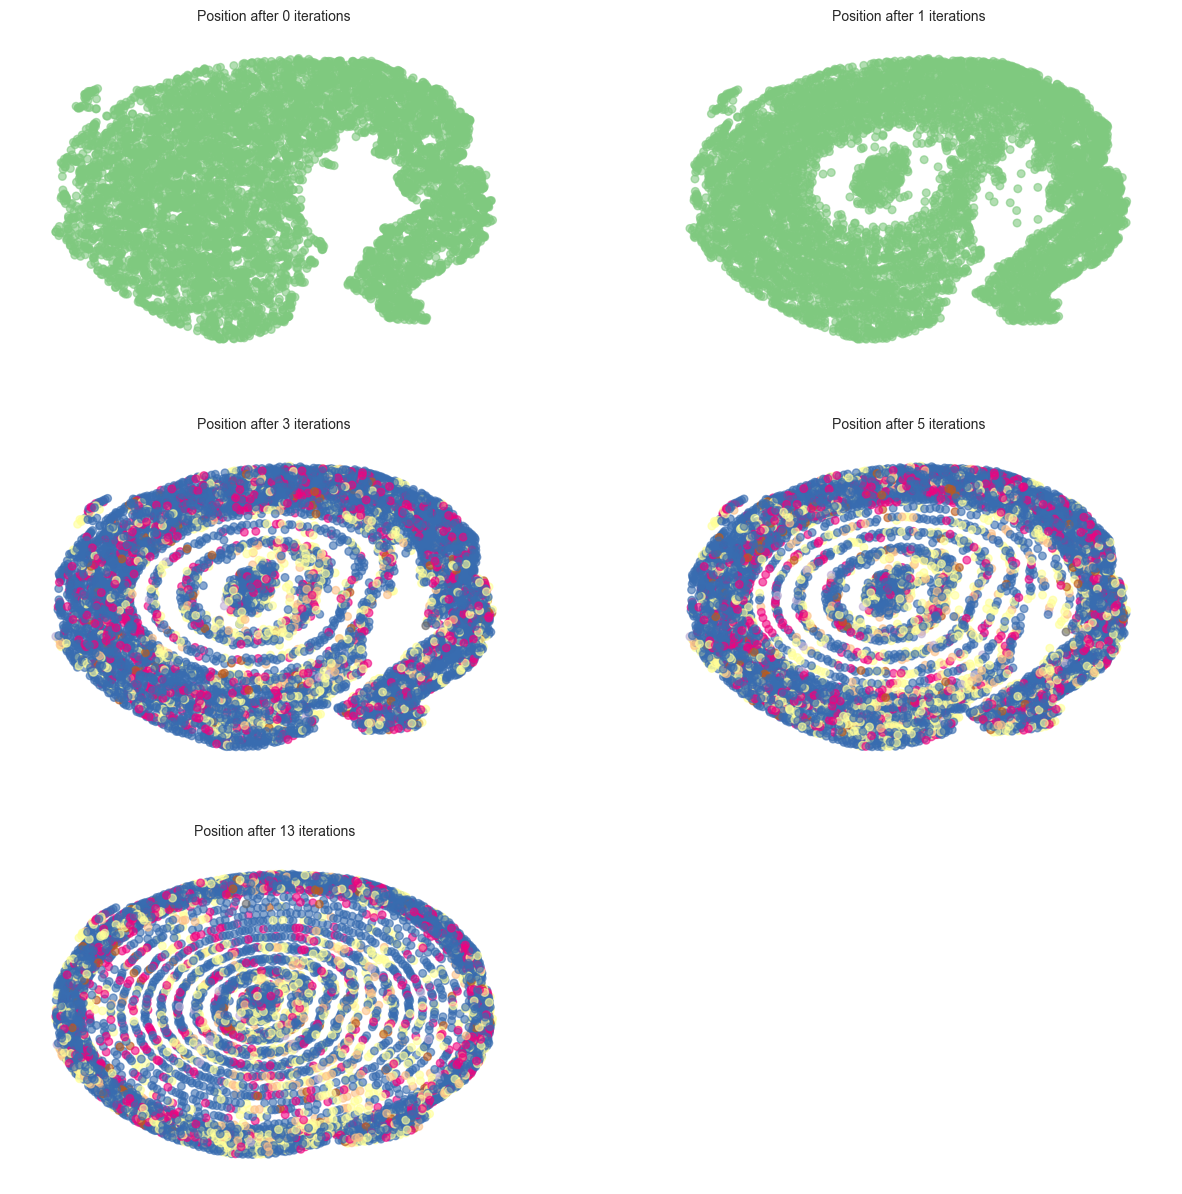

In [23]:
visualization.display_graphs(force_iterations,
                             2,
                             labels=sequence_changes,
                             # cmap=plt.cm.inferno,
                             show_cbar=False,
                             show_edges=False,
                             )

## Dash-Exploration

In [12]:
utils.save_pickle(force_iterations)

In [17]:
force_iterations = utils.load_pickle(filename="results_20250327-171811")

In [18]:
dash_app = DashOverlay(force_iterations)

In [19]:
dash_app.run()

## Workflow Example

In [ ]:
# fetch dataset
image_segmentation = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets, dtype="float32")

# metadata
print(image_segmentation.metadata)

# variable information
print(image_segmentation.variables)

In [6]:
# fetch dataset
image_segmentation = fetch_ucirepo(id=50)

# data (as pandas dataframes)
X = pd.DataFrame(image_segmentation.data.features, dtype="float32")
y = pd.DataFrame(image_segmentation.data.targets)

# metadata
print(image_segmentation.metadata)

# variable information
print(image_segmentation.variables)

{'uci_id': 50, 'name': 'Image Segmentation', 'repository_url': 'https://archive.ics.uci.edu/dataset/50/image+segmentation', 'data_url': 'https://archive.ics.uci.edu/static/public/50/data.csv', 'abstract': 'Image data described by high-level numeric-valued attributes, 7 classes', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2310, 'num_features': 19, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1990, 'last_updated': 'Fri Oct 27 2023', 'dataset_doi': '10.24432/C5GP4N', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': 'The instances were drawn randomly from a database of 7 outdoor images.  The images were handsegmented to create a classification for every pixel.  \r\n\r\n   Each instance is a 3x3 region.', 'purpose': None, 'funded_by': None, 'instances_represent': None, 'recommended_dat

In [7]:
umap_mapper = umap.UMAP(n_neighbors=15, min_dist=1, random_state=0)
umap_mapper.fit(X)
umap_embedding = umap_mapper.embedding_

D:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Software-Projekte\Uni\master_thesis\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
embeddings = processing.fit(X, umap_embedding, ["saturation-mean"],
                            iterations=[1, 3, 5, 10])

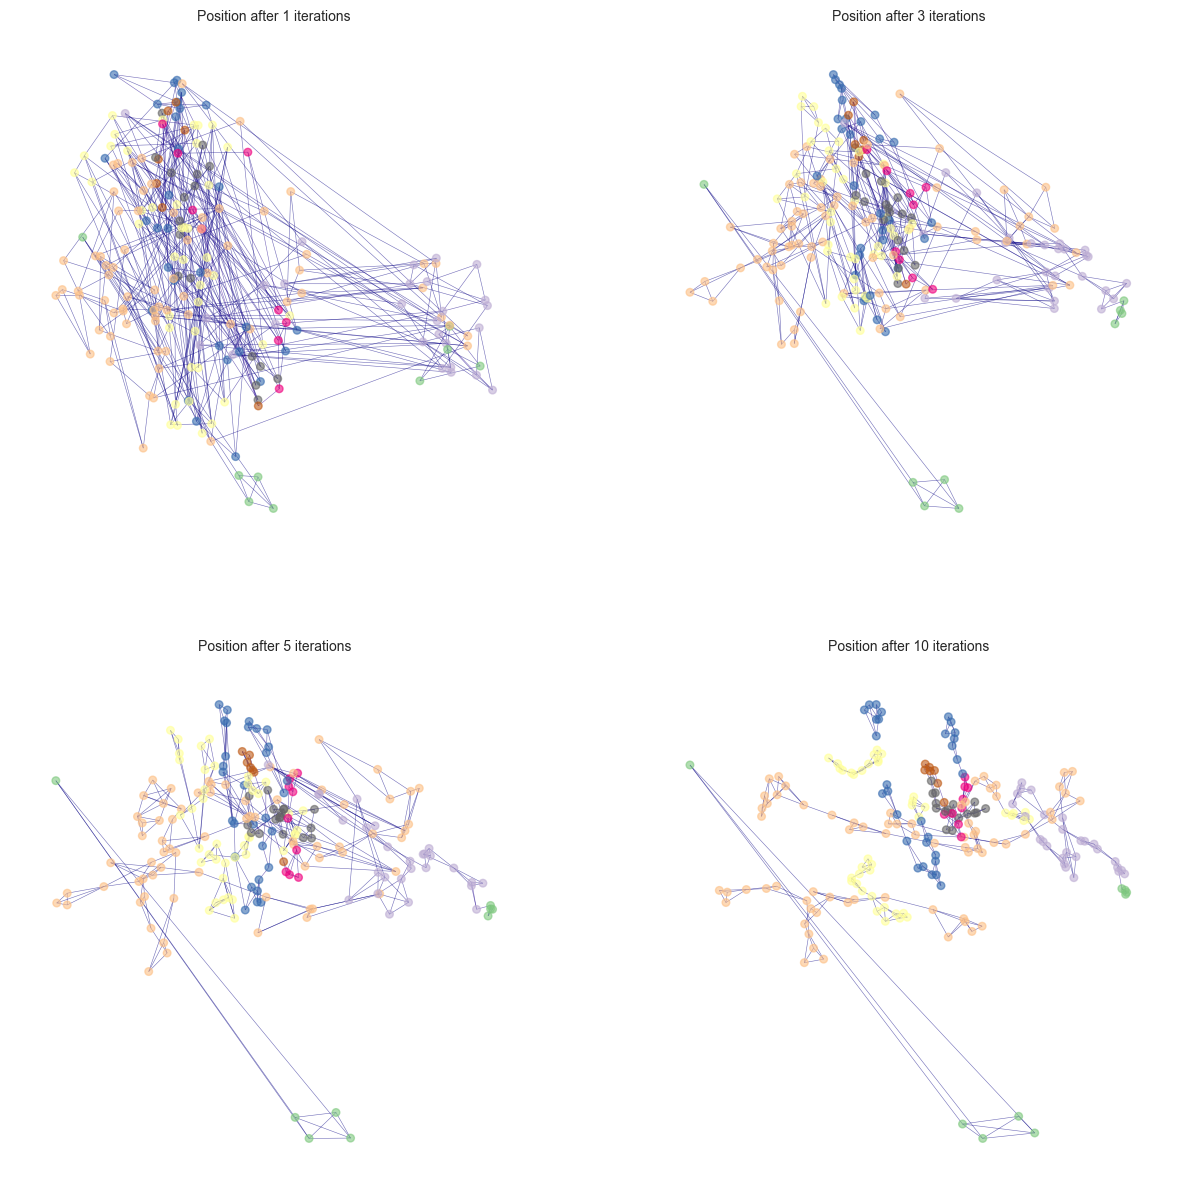

In [9]:
visualization.display_graphs(embeddings, labels=X["saturation-mean"], show_cbar=False)

In [10]:
embeddings = evaluation.add_local_metrics(X, embeddings)

------------------------------------------------------------
Computing metrics for embedding with marker:  1
------------------------------------------------------------
Computing metrics for embedding with marker:  3
------------------------------------------------------------
Computing metrics for embedding with marker:  5
------------------------------------------------------------
Computing metrics for embedding with marker:  10


In [11]:
embeddings = evaluation.add_global_metrics(umap_mapper._raw_data, embeddings)

------------------------------------------------------------
Computing metrics for embedding with marker:  1
------------------------------------------------------------
Computing metrics for embedding with marker:  3
------------------------------------------------------------
Computing metrics for embedding with marker:  5
------------------------------------------------------------
Computing metrics for embedding with marker:  10


In [12]:
embeddings[0].metrics_info()

---------------------------------------
Embedding object (Marker: 1)
Total score: 0.743696445590154
Jaccard-Scores: 210 (values)
Q local: 0.44001590289077114
Trustworthiness: 0.9246017126500745
Continuity: 0.9246017126500745
Spearman Score: 0.42926289975985
Normalized Stress: 0



In [15]:
metrics_df = evaluation.metrics_report(embeddings)
metrics_df

marker  m_total_score  metric_jaccard (size)  m_q_local  m_trustworthiness  \
0     1.0       0.743696                  210.0   0.440016           0.924602   
1     3.0       0.745597                  210.0   0.296938           0.878009   
2     5.0       0.750181                  210.0   0.233129           0.846938   
3    10.0       0.752357                  210.0   0.200696           0.824704   

   m_continuity  m_spearman  m_normalized_stress  
0      0.924602    0.429263                  0.0  
1      0.878009    0.675029                  0.0  
2      0.846938    0.823901                  0.0  
3      0.824704    0.911679                  0.0

In [31]:
df_melted = metrics_df.drop("metric_jaccard (size)", axis=1).melt(id_vars="marker",
                                                                  var_name="Feature",
                                                                  value_name="Value")

<Axes: xlabel='marker', ylabel='Value'>

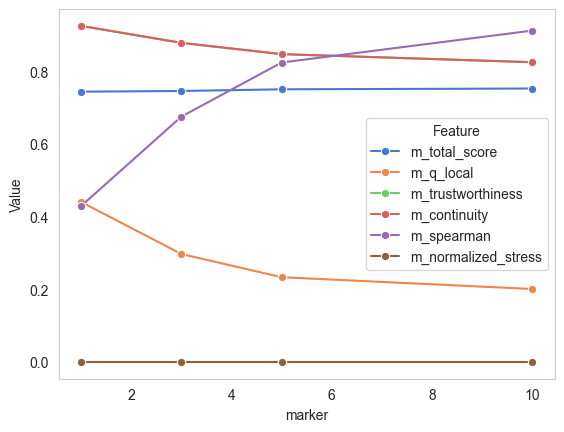

In [45]:
sb.set_style("whitegrid", {'axes.grid': False})
sb.lineplot(data=df_melted, x="marker", y="Value", hue="Feature", palette="muted",
            marker="o")

In [31]:
dash_app = DashOverlay(embeddings)
dash_app.run()

In [46]:
from dash_example import Dash

test = Dash()

In [50]:
test.run(jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/
